# [OpenCV-Python Tutorial] Classification

In this notebook, we will learn how to perform Object Classification using Visual Bag of Words(VBoW), spatial histogram feature, and SVM classifier.

---

In [1]:
#!pip install opencv-python==3.4.2.17
#!pip install opencv-contrib-python==3.4.2.17

In [2]:
import os, sys
import tarfile
import time
import random
import pickle
from glob import glob

import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
print(cv2.__version__)

3.4.2


In [3]:
# download dataset
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp" -O 101_ObjectCategories.tar.gz && rm -rf /tmp/cookies.txt

In [4]:
caltech_url = 'http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz'
caltech_filename = '101_ObjectCategories.tar.gz'
caltech_dir = '101_ObjectCategories/'

numTrain = 15
numTest = 15
numClasses = 102
numWords = 600

vocabPath = 'vocab.pkl'
svmPath = os.path.join(caltech_dir, 'svm_data.dat')

# Dataset

## 1. Download Caltech-101 dataset

In [5]:
if not os.path.exists(caltech_dir) or not os.path.exists(os.path.join(caltech_dir, 'airplanes')):
    print('Extracting Caltech-101')
    with tarfile.open(caltech_filename) as tar:
        tar.extractall()

print('Caltech-101 dataset checked')

Caltech-101 dataset checked


## 2. Setup Data

# Dense SIFT(PHOW) and Visual Words

Select 15 train/test images for each class
done


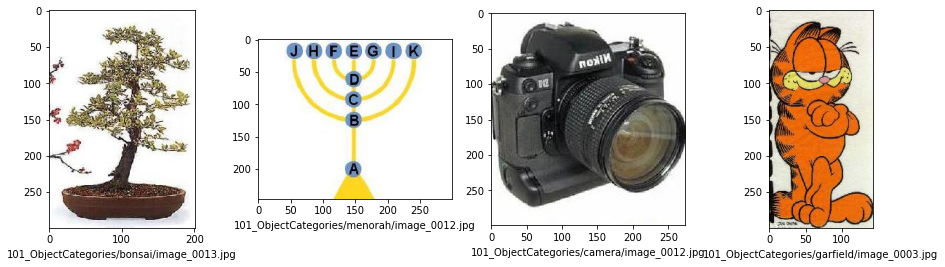

In [6]:
# Select 15 train/test images for each class
print('Select 15 train/test images for each class')
classes = next(os.walk(caltech_dir))[1]
train_image_ll = []
test_image_ll = []
for c in classes:
    class_dir = os.path.join(caltech_dir, c, '*.jpg')
    ims = glob(class_dir)
    ims.sort()
    train_image_ll.append([f for f in ims[:numTrain]])
    test_image_ll.append([f for f in ims[numTrain:numTrain+numTest]])
print('done')

# Show 4 random images
plt.figure(figsize=(16,4))
for i, idx in enumerate(random.sample(range(len(classes)), 4)):
    fpath = random.sample(train_image_ll[idx], 1)[0]
    plt.subplot(1, 4, i+1)
    plt.imshow(cv2.cvtColor(cv2.imread(fpath), cv2.COLOR_BGR2RGB))
    plt.xlabel(fpath)

## 1. SIFT helper functions

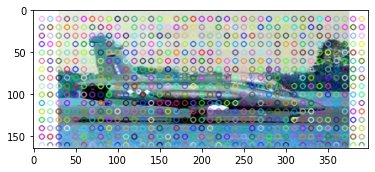

In [7]:
sift = cv2.xfeatures2d.SIFT_create()

# Resize a image if it's too large
def standarizeImage(img):
    rows, cols = img.shape
    if cols > 480:
        img = cv2.resize(img, (480, int(rows*480/cols)))
    return img

# Detect and extract SIFT from a single image
def SIFT(img):
    kp, des = sift.detectAndCompute(img, None)
    return kp, des

# Load an image + Resize if large + Extract SIFT
def SIFT2(img_fpath):
    img = cv2.imread(img_fpath, cv2.IMREAD_GRAYSCALE)
    img = standarizeImage(img)
    return SIFT(img)

# Dense SIFT(Extract SIFT descriptor in grid points over an image)
def denseSIFT(img, step = 10, size = 7):
    rows, cols = img.shape[:2]
    kp = []
    for x in range(step,cols,step):
        for y in range(step,rows,step):
            kp.append(cv2.KeyPoint(x, y, size))
    kp, des = sift.compute(img, kp)
    return kp, des

# Load an image + Resize if large + Dense SIFT
def denseSIFT2(img_fpath, step = 10):
    img = cv2.imread(img_fpath, cv2.IMREAD_GRAYSCALE)
    img = standarizeImage(img)
    return denseSIFT(img, step)

# Dense SIFT
tmp_im = cv2.cvtColor(cv2.imread(train_image_ll[0][0]), cv2.COLOR_BGR2RGB)
#kp, des = SIFT(tmp_im)
kp, des = denseSIFT(tmp_im)
im_sift = cv2.drawKeypoints(tmp_im, kp, None)
plt.imshow(cv2.cvtColor(im_sift, cv2.COLOR_BGR2RGB))

## 2. Visual Words(Train Vocabulary)

In [8]:
# Download pre-extracted vocab.pkl
# !wget https://raw.githubusercontent.com/bckim92/iab_practice_example/master/vocab.pkl

In [9]:
# Train vocabulary
if not os.path.exists(vocabPath):
    # Get PHOW features from 30 random training image to build a dictionary
    print("Extracting PHOW features some training images...")
    PHOW_descrs = []
    temp = [item for sublist in train_image_ll for item in sublist]
    temp = random.sample(temp, 30)
    for fpath in temp:
        _, des = denseSIFT2(fpath)
        PHOW_descrs.append(des)
    PHOW_descrs = np.concatenate(PHOW_descrs, axis=0)
    print("Total {} PHOW features".format(PHOW_descrs.shape[0]))
    
    # Quantize the descriptors to get the visual words
    print("Running K-means clustering ({} -> {})...".format(PHOW_descrs.shape[0], numWords))
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 500, 1.0)
    attempts = 1
    flags = cv2.KMEANS_RANDOM_CENTERS
    start_time = time.time()
    retval, bestLabels, vocab = cv2.kmeans(PHOW_descrs, numWords, None, criteria, attempts, flags)
    print('Elapsed time: {:6}s'.format(time.time() - start_time))
    
    print('Saving...') 
    with open(vocabPath, 'wb') as fd:
        pickle.dump(vocab, fd)
else:
    print("Load the trained visual words...")
    with open(vocabPath, 'rb') as fd:
        vocab = pickle.load(fd)

print('Done!')

Load the trained visual words...
Done!


In [10]:
# import collections
# myCounter = collections.Counter(bestLabels.flatten())
# plt.plot(sorted(myCounter.values()))

# Classification - SVM

## Spatial Histogram

In [11]:
bf = cv2.BFMatcher()

def getImageDescriptor(img, step=10, size=7):
    img = standarizeImage(img)
    cols, rows = img.shape[:2]
    
    # Extracting denseSIFT and BoW
    kp = []
    for x in range(step,cols,step):
        for y in range(step,rows,step):
            kp.append(cv2.KeyPoint(x, y, size))
    kp, des = sift.compute(img, kp)
    matches = bf.knnMatch(des, vocab, k=1)
    words = [m[0].trainIdx for m in matches]
    
    # Spatial Binning - 2x2
    binX = 2; binY = 2;
    temp = np.zeros((binX, binY, numWords), dtype=np.float32)
    for k, w in zip(kp, words):
        i = int((k.pt[0]) * binX / cols)
        j = int((k.pt[1]) * binY / rows)
        temp[i, j, w] += 1
    for i in range(binX):
        for j in range(binY):
            temp[i, j, :] /= np.sum(temp[i, j, :])
    temp = temp.flatten()
    hist = temp
    
    # Spatial Binning - 4x4
    ################################
    # TODO : your code here
    binX = 4; binY = 4;
    temp = np.zeros((binX, binY, numWords), dtype=np.float32)
    for k, w in zip(kp, words):
        i = int((k.pt[0]) * binX / cols)
        j = int((k.pt[1]) * binY / rows)
        temp[i, j, w] += 1
    for i in range(binX):
        for j in range(binY):
            temp[i, j, :] /= np.sum(temp[i, j, :])
    temp = temp.flatten()
    ################################
    hist = np.concatenate((hist, temp), axis=0)
    
    hist /= np.sum(hist)
    return hist    

## 1. Genarate spatial histogram for Training Images

In [12]:
# Extract spartial histogram for all training images
print('Extract spartial histogram for all training images')
BoW_train_ll = []
for c, image_list in zip(classes, train_image_ll):
    print(c, end=' '), 
    temp = []
    for fpath in image_list:
        img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
        temp.append(getImageDescriptor(img))
    BoW_train_ll.append(temp)

print('\ndone!')

Extract spartial histogram for all training images
airplanes crocodile dolphin headphone kangaroo soccer_ball stegosaurus Faces trilobite cellphone strawberry dalmatian anchor euphonium llama binocular pyramid minaret cannon garfield dollar_bill grand_piano wrench flamingo ketch watch gerenuk mayfly octopus butterfly lamp scorpion inline_skate okapi crab mandolin windsor_chair elephant hawksbill laptop umbrella BACKGROUND_Google tick pagoda yin_yang pigeon Leopards helicopter Motorbikes cougar_face pizza snoopy sea_horse barrel flamingo_head rhino car_side joshua_tree stapler bass scissors ferry emu hedgehog water_lilly dragonfly gramophone ceiling_fan schooner saxophone brontosaurus ant starfish electric_guitar crocodile_head brain panda stop_sign wild_cat menorah ewer revolver accordion bonsai ibis crayfish chair wheelchair camera lobster nautilus rooster Faces_easy beaver cougar_body chandelier platypus cup buddha sunflower metronome lotus 
done!


## 2. Train SVM

In [13]:
# Setting training data(BoW, label) for SVM
print('Setting training data(BoW, label) for SVM')
train_bow = []
train_labels = []
numSpartialHist = len(BoW_train_ll[0][0])
for i, BoW_list in enumerate(BoW_train_ll):
    for bow in BoW_list:
        # Hellinger's kernel for each training instance(bow)
        temp = np.sqrt(bow)
        temp -= np.average(temp)
        if np.std(temp) != 0:
            temp /= np.std(temp)
        train_bow.append([temp])
    train_labels.extend([i] * len(BoW_list))
train_bow = np.concatenate(train_bow, axis=0).astype(np.float32)
train_labels = np.array(train_labels, dtype=np.int).reshape((numTrain*numClasses,1))
# => train_bow: (1530, 12000), train_labels: (1530,1)

print("train_bow: ", str(train_bow.shape))
print("train_labels: ", str(train_labels.shape))

Setting training data(BoW, label) for SVM
train_bow:  (1530, 12000)
train_labels:  (1530, 1)


/home/zendo/anaconda3/envs/iab/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  app.launch_new_instance()


In [14]:
# Train SVM
print('Training SVM...')
svm = cv2.ml.SVM_create()
svm.setType(cv2.ml.SVM_C_SVC)
svm.setKernel(cv2.ml.SVM_LINEAR)
svm.setC(0.01)
svm.setTermCriteria((cv2.TERM_CRITERIA_COUNT, 10, 1.0))

start_time = time.time()
# svm.train(SVM_train_data)
svm.train(train_bow, cv2.ml.ROW_SAMPLE, train_labels)
print('Elapsed time: {:6}s'.format(time.time() - start_time))

# print 'Saving SVM...'
# svm.save(svmPath)
print('Done!')

Training SVM...
Elapsed time: 9.879009485244751s
Done!


In [15]:
train_preds = svm.predict(train_bow)[1]
print('Training Accuracy: %.6f' % np.average(train_preds == train_labels))

Training Accuracy: 0.987582


## 3. Test trained SVM

In [16]:
# Extract spartial histogram for all test images
################################
# TODO : your code here
print('Extract spartial histogram for all test images\n')
BoW_test_ll = []
for c, image_list in zip(classes, test_image_ll):
    print(c, end=' '), 
    temp = []
    for fpath in image_list:
        img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
        temp.append(getImageDescriptor(img))
    BoW_test_ll.append(temp)
print('\ndone!')
################################

Extract spartial histogram for all test images

airplanes crocodile dolphin headphone kangaroo soccer_ball stegosaurus Faces trilobite cellphone strawberry dalmatian anchor euphonium llama binocular pyramid minaret cannon garfield dollar_bill grand_piano wrench flamingo ketch watch gerenuk mayfly octopus butterfly lamp scorpion inline_skate okapi crab mandolin windsor_chair elephant hawksbill laptop umbrella BACKGROUND_Google tick pagoda yin_yang pigeon Leopards helicopter Motorbikes cougar_face pizza snoopy sea_horse barrel flamingo_head rhino car_side joshua_tree stapler bass scissors ferry emu hedgehog water_lilly dragonfly gramophone ceiling_fan schooner saxophone brontosaurus ant starfish electric_guitar crocodile_head brain panda stop_sign wild_cat menorah ewer revolver accordion bonsai ibis crayfish chair wheelchair camera lobster nautilus rooster Faces_easy beaver cougar_body chandelier platypus cup buddha sunflower metronome lotus 
done!


In [17]:
# Setting test data(BoW, label) for SVM
print('Setting test data(BoW, label) for SVM')
################################
# TODO : your code here
test_bow = []
test_labels = []
numSpartialHist = len(BoW_test_ll[0][0])
for i, BoW_list in enumerate(BoW_test_ll):
    for bow in BoW_list:
        # Hellinger's kernel for each training instance(bow)
        temp = np.sqrt(bow)
        temp -= np.average(temp)
        if np.std(temp) != 0:
            temp /= np.std(temp)
        test_bow.append([temp])
    test_labels.extend([i] * len(BoW_list))

# TODO : inference code here
test_bow = np.concatenate(test_bow, axis=0).astype(np.float32)
test_labels = np.array(test_labels, dtype=np.int).reshape((numTrain*numClasses,1))
# => test_bow: (1530, 12000), test_labels: (1530,1)

print(test_bow.shape)
print(test_labels.shape)
################################

Setting test data(BoW, label) for SVM
(1530, 12000)
(1530, 1)


/home/zendo/anaconda3/envs/iab/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [18]:
test_preds = svm.predict(test_bow)[1]
print('Test Accuracy: {:6}'.format(np.average(test_preds == test_labels)))

Test Accuracy: 0.41241830065359475


## 4. Sample Results

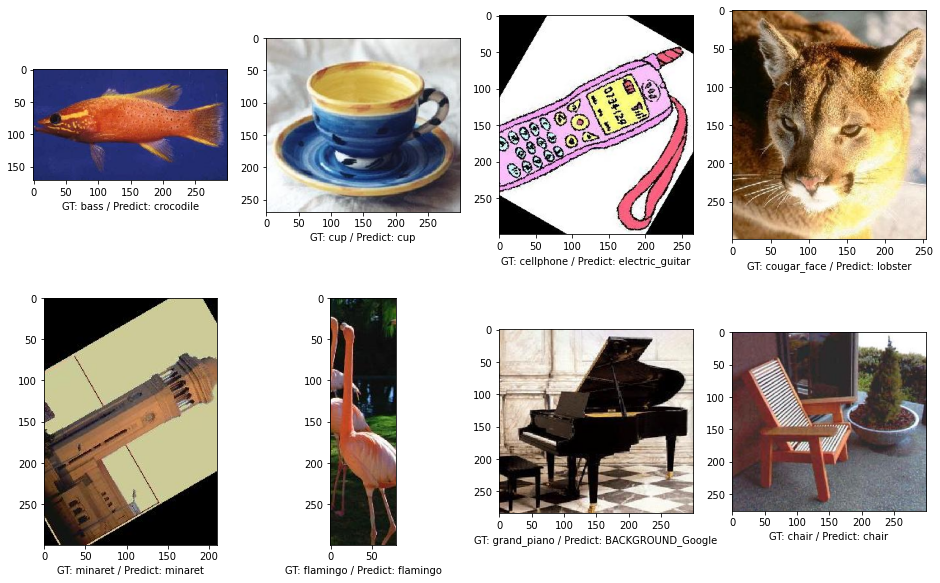

In [19]:
# Show 8 random images
plt.figure(figsize=(16,10))
for i, r_c in enumerate(random.sample(range(len(classes)), 8)):
    # Random sample image from given class
    r_i = random.sample(range(numTest), 1)
    fpath = train_image_ll[r_c][r_i[0]]
    img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
    
    # Get predicted label
    test_res = int(test_preds[r_c * numTest + r_i[0]][0])
    
    plt.subplot(2, 4, i+1)
    plt.imshow(cv2.cvtColor(cv2.imread(fpath), cv2.COLOR_BGR2RGB))
    plt.xlabel("GT: {} / Predict: {}".format(classes[r_c], classes[test_res]))

# Practice: Classify your own image

Choose and classify your own test image using our classification.

- Place your image in the path where this notebook can access
- Load an image as grayscale
- Extract Dense SIFT BoW with `getImageDescriptor()`
- Normalize the bow with Hellinger's kernel
- Predict using the SVM classifier we have trained so far(`svm` instance)

In [20]:
# !wget https://raw.githubusercontent.com/gendo7985/IAB_2021/main/week2/CV/laptop.jpg

--2021-09-17 15:58:22--  https://raw.githubusercontent.com/gendo7985/IAB_2021/main/week2/CV/laptop.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52820 (52K) [image/jpeg]
Saving to: ‘laptop.jpg.1’

laptop.jpg.1        100%[===================>]  51.58K  --.-KB/s    in 0.04s   

2021-09-17 15:58:22 (1.36 MB/s) - ‘laptop.jpg.1’ saved [52820/52820]



Text(0.5, 0, 'Prediction: wrench')

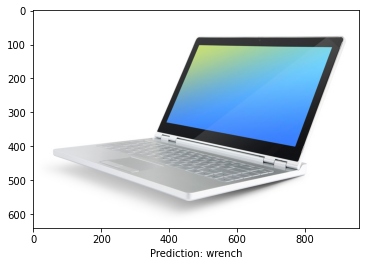

In [21]:
img_fpath = './laptop.jpg'  # Path to your own image
img = cv2.imread(img_fpath, cv2.IMREAD_GRAYSCALE)

#================ YOUR CODE HERE ===================
bow = getImageDescriptor(img)
# Hellinger's kernel for my own bow
test_bow = np.sqrt(bow)
test_bow -= np.average(test_bow)
if np.std(test_bow) != 0:
    test_bow /= np.std(test_bow)

test_pred = svm.predict(np.asarray(test_bow).reshape(1,12000))[1]
prediction = int(test_pred[0][0])  # Predicted class of your image
#===================================================

plt.imshow(cv2.cvtColor(cv2.imread(img_fpath), cv2.COLOR_BGR2RGB))
plt.xlabel("Prediction: {}".format(classes[prediction]))

In [22]:
# Desired output : laptop